In [2]:
import os

import numpy as np
import pandas as pd
import pickle 

from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

# Plots
import matplotlib.pyplot as plt

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

import logging
logging.raiseExceptions = False


In [3]:
pd.set_option('display.max_rows', 10)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

## Dataset general preparation

In [4]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df = df.set_index(["case", "t_point"])
df = df.sort_values(["case", "t_point"])
dynamic_idx = list(range(29, 42))
dynamic_columns = list(df.columns[dynamic_idx])
df.loc[:, dynamic_columns]

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

#### Divide it on blocks

We will take from one to four last records and predict next vector

In [5]:
full_df = df.copy()
full_df

омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                        

Exclude columns, which give information about how long and about result

In [6]:
df = df.drop(["end_epizode", "admission_date", "current_process_duration", "process_stages", "outcome_tar", "long_observation_tar"], axis=1)

In [7]:
df.loc[df.index.levels[0][1]]

,омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact,age_stat_fact,трансфузия_dinam_control,оксигенотерапия_dinam_control,НИВЛ_dinam_control,ИВЛ_dinam_control
t_point,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,1.21,20.7,55.0,22.0,7.8,8.1,0.201,24.1,0,1,189.0,17.7,73,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,2.09,21.0,72.0,18.0,8.8,7.0,0.204,33.2,0,5,NaN,19.8,73,0,0,0,0


In [8]:
df.loc[df.index.levels[0][10]]

,омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact,age_stat_fact,трансфузия_dinam_control,оксигенотерапия_dinam_control,НИВЛ_dinam_control,ИВЛ_dinam_control
t_point,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,NaN,1.09,30.3,NaN,18.0,7.5,7.1,0.173,27.3,0,1,180.0,16.1,72,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,NaN,1.06,31.0,44.0,18.0,NaN,6.5,0.187,16.1,0,5,NaN,21.0,72,0,0,0,0


Разберем одну историю пациента GACAAcY на векторы

In [9]:
t = df.groupby(level=0).nunique().iloc[:, 42:]
pd.DataFrame(t.value_counts())

0
age_stat_fact трансфузия_dinam_control оксигенотерапия_dinam_control НИВЛ_dinam_control ИВЛ_dinam_control      
1             1                        1                             1                  1                  1619
                                       2                             1                  1                   184
                                       1                             1                  2                    61
              2                        1                             1                  2                    34
                                                                                        1                    30
...                                                                                                         ...
                                       2                             1                  2                     6
                                       1                             2                  1                     5
              1                        2                             2                  1                     3
              2                        2                             2                  2                     3
              1                        2                             2                  2                     2

[15 rows x 1 columns]

In [10]:
t = df.groupby(level=0).nunique().iloc[:, :29]
pd.DataFrame(t.value_counts())

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0
омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1992


По лекарствам у всех пациентов набор препаратов не менялся, а по процедурам у 380 пациентов изменялся порядок. Из этого сделаем вывод, что можно выделить лекарства и возраст в один вектор, а процедуры не разбираем

Уберем всех пациентов лечившихся меньше 1 недели

In [11]:
s = df.groupby(level=0).size()
df = df.loc[s[s>1].index.values]

Отделим части для обучения и тестирования

In [12]:
test_index = np.random.choice(s.index, 100, replace=False)
train_index = np.array([idx for idx in s.index if idx not in test_index])
df_test = df.loc[test_index, :, :]
df_train = df.loc[train_index, :, :]

C:\Users\sirau\AppData\Local\Temp\ipykernel_18648\2566532452.py:3: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_test = df.loc[test_index, :, :]
C:\Users\sirau\AppData\Local\Temp\ipykernel_18648\2566532452.py:4: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_train = df.loc[train_index, :, :]


### Лимфоциты
Меня интересует зависимость параметров Лимфоциты# и Лимфоциты%

Text(0.5, 1.0, 'Зависимость распределения \n Лимфоциты% от Лимфоциты#')

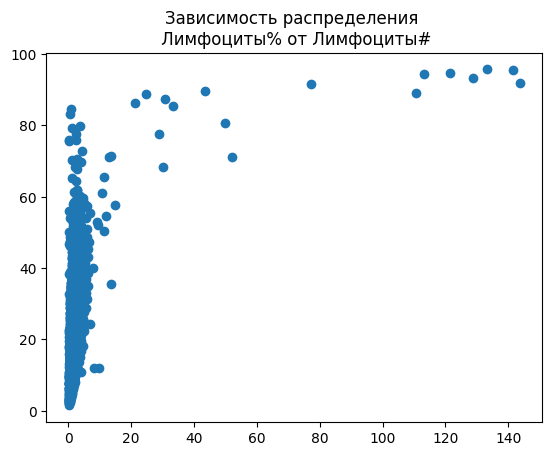

In [13]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
plt.scatter(data[:,0], data[:, 1])
plt.title("Зависимость распределения \n Лимфоциты% от Лимфоциты#")

Text(0.5, 1.0, 'Распределение величины Лимфоциты#_dinam_fact')

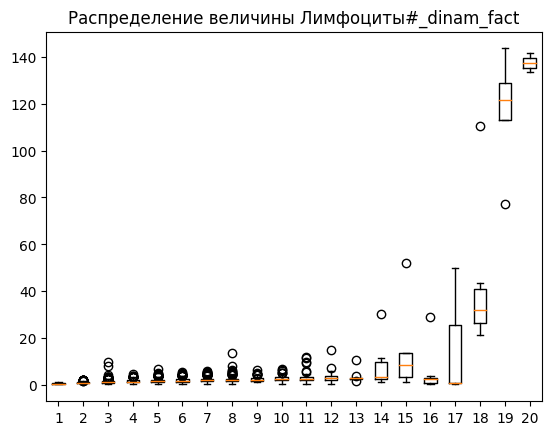

In [14]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты%_dinam_fact"]>i) & (df["Лимфоциты%_dinam_fact"]<i+5)]["Лимфоциты#_dinam_fact"] for i in range(0, 100, 5)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты#_dinam_fact")

Text(0.5, 1.0, 'Распределение величины Лимфоциты%_dinam_fact')

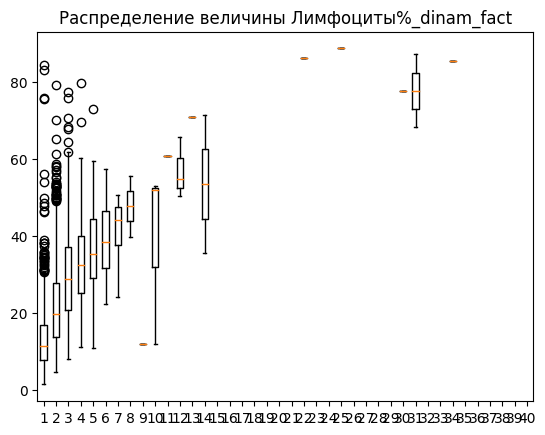

In [15]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты#_dinam_fact"]>i) & (df["Лимфоциты#_dinam_fact"]<i+1)]["Лимфоциты%_dinam_fact"] for i in range(0, 40, 1)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты%_dinam_fact")

Получается, что чистой корреляции у них нет. Однако чем выше количество лимфоцитов, тем больше их часть среди других лейкоцитов. Корреляцию Пирсона получаем 0.35 (P < 1e-159)

In [16]:
from scipy.stats import pearsonr
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = data[~np.isnan(data[:, 0]) & ~np.isnan(data[:, 1]) , :]
pearsonr(data[:, 0], data[:, 1])

PearsonRResult(statistic=0.35366027434981473, pvalue=5.609278436072053e-159)

## Обучение

Теперь разделим датасет на окна - одна запись как фича, другая как таргет. И среди всех записей пациента проведем такую операцию

In [17]:
X , y = [], []
for i in df_train.index.levels[0]:
    try:
        for j in range(df_train.loc[i].index.size - 1):
            try:
                X.append(df_train.loc[(i, j)])
                y.append(df_train.loc[(i, j+1)].iloc[29:42])
            except:
                pass
    except:
        pass
X, y = np.array(X), np.array(y)

Уберем nan значения таргета, и каждому из 13-ти параметров соотнесем пары - вектор параметров X и вектор значений Y. Получим для каждого параметра датафрейм векторов состояния и следующие значения парамтера

In [50]:
data = {param: [] for param in dynamic_columns}
for i in range(len(data)):
    X_temp, y_temp = [], []
    for j in range(y.shape[0]):
        if not np.isnan(y[j][i]):
            X_temp.append(X[j])
            y_temp.append(y[j][i])
    data[dynamic_columns[i]] = {"X": np.array(X_temp), "y": np.array(y_temp)}

Теперь посмотрим, сколько пар для обучения у нас присутствует

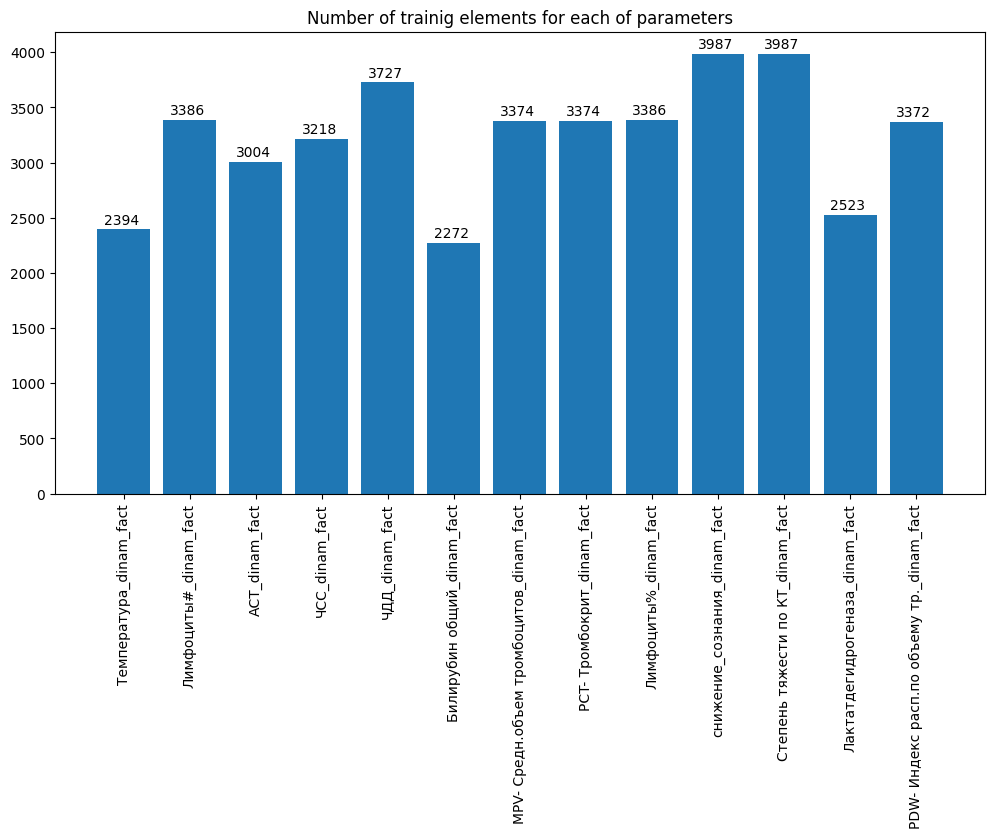

In [51]:
stat_nan = {k:len(data[k]["X"]) for k in data}
l = stat_nan.keys()
h = stat_nan.values()
plt.figure(figsize=(12, 6))
plt.bar(x=l, height=h)
plt.xticks(rotation=90)
plt.title("Number of trainig elements for each of parameters")
for key_idx, key in enumerate(stat_nan):
  plt.text(key_idx-0.3,stat_nan[key]+50,stat_nan[key])

Нам важно измерить качество регрессии. Будем вычислять R2, MSE, mAPE и 95% интервалы этих метрик. Для доверительных интервалов будем использовать значения метрик модели на 5 фолдах (иными словами кросс валидацию)

In [20]:
import scipy.stats as st
def get_scores(y_real, y_pred):
    scores = {}
    scores["r2"] = r2_score(y_real, y_pred, multioutput="raw_values")
    scores["mse"] = mean_squared_error(y_real, y_pred, multioutput="raw_values")
    scores["mape"] = mean_absolute_percentage_error(y_real, y_pred, multioutput="raw_values")
    return scores

def evaluate_with_intervals(clf, X, y, folds=5):
    scoring_results = {"r2":[], "mape":[], "mse":[]}
    kf = KFold(folds)
    k = 0
    for train, test in kf.split(X, y):
        clf.fit(X[train], y[train])
        print(f"Model fitted on fold {k} / {folds}")
        y_pred = clf.predict(X[test])
        validation_data = get_scores( y[test], y_pred)
        for sc in scoring_results:
            scoring_results[sc].append(validation_data[sc])
        k+=1
    data_df = {}
    for metric in scoring_results:
        dataz = scoring_results[metric]
        interval  = st.t.interval(confidence=0.95 , df=len(dataz), loc=np.mean(dataz), scale=st.sem(dataz))
        data_df["max_"+metric] = interval[1]
        data_df["min_"+metric] = interval[0]
        data_df["avg_"+metric] = (interval[1]+interval[0])/2
    df_metrics = pd.DataFrame(data_df, index=[0])
    return df_metrics

Чтобы обьективно понимать, что будущие модели будут улавливать закономерности а не рандомно делать свои ответы, попробуем возвращать только среднее значение параметра по всем возможным наблюдениям и после сравним эффективность такого подхода с моделью машинного обучения

### HistGradientBoostingRegressor

Сделаем модели на каждый параметр с простенькой моделью HistGradientBoostingRegressor (она единственная из sklearn ргегрессоров поддерживает NaN)

In [21]:
evaluate_with_intervals(model, X_param, y_param)

NameError: name 'model' is not defined

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
model = HistGradientBoostingRegressor()
parameters_validation = []

for col in dynamic_columns:
    X_param, y_param = data[col]["X"], data[col]["y"]
    metrics = evaluate_with_intervals(model, X_param, y_param)
    metrics["column"] = col
    metrics["model"] = "HistGradientBoosting"
    parameters_validation.append(metrics)
    print(f" LOG: parameter {col} finished")

In [ ]:
result_table = pd.concat(parameters_validation, axis=0)
result_table.to_csv("HistGradientBoostingRegressor_metrics_with_interval.csv")
result_table

Сравним результат с LinearRegression

In [ ]:
import pickle
model = LinearRegression() #Fedot(problem='regression', timeout=10, n_jobs=-1)
parameters_validation = []
for col in dynamic_columns:
    X_param, y_param = data[col]["X"], data[col]["y"]
    X_param = np.apply_along_axis(np.nan_to_num, 1, X_param, {"nan":X_param.mean()})
    metrics = evaluate_with_intervals(model, X_param, y_param)
    metrics["column"] = col
    metrics["model"] = "LinearRegression"
    parameters_validation.append(metrics)
result_table = pd.concat(parameters_validation, axis=0)
result_table.to_csv("LinearRegression_metrics_with_interval.csv")
result_table

In [ ]:
model = Fedot(problem='regression', timeout=10, n_jobs=-1)
parameters_validation = []
for col in list(data.keys()):
    X_param, y_param = data[col]["X"], data[col]["y"]
    metrs = evaluate_with_intervals(model, X_param, y_param)
    metrs["Parameter"] = col  
    metrs["Model"] = "Fedot regression"
    parameters_validation.append(metrs)

Соберем пайплайны и сохраним их на диске для дальнейшего использования

In [ ]:
for col in list(data.keys()):
    model = Fedot(problem='regression', timeout=1, n_jobs=-1)
    X_param, y_param = data[col]["X"], data[col]["y"]
    obtained_pipeline = model.fit(X_param, y_param)
    obtained_pipeline.save(f"fedot_pipelines\\{col}", datetime_in_path=False)

Далее представлен код инференса модели: берем вектор текущих значений и последовательно всеми моделями предсказываем параметры

In [103]:
#вОЗЬМЕМ ПЕРВЫЙ ВЕКТОР ТРЕНИРОВОЧНОГО НАБОРА ДЛЯ ТЕСТА
df_orig = 
df.groupby("case").last()

,омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact,age_stat_fact,трансфузия_dinam_control,оксигенотерапия_dinam_control,НИВЛ_dinam_control,ИВЛ_dinam_control
case,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GACAAcY,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,36.5,2.12,27.00,71.0,18.0,12.10,11.4,0.100,24.1,0,5,274.00,13.1,81,0,1,0,0
GACAAnf,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,2.09,21.00,72.0,18.0,8.80,7.0,0.204,33.2,0,5,189.00,19.8,73,0,0,0,0
GACABsT,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,36.6,2.04,27.60,84.0,17.0,5.00,10.3,0.360,17.6,0,5,255.00,12.4,59,0,0,0,0
GACACKP,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,36.5,1.96,28.40,78.0,19.0,11.90,12.1,0.190,13.0,0,5,249.00,15.6,71,0,0,0,0
GACADBj,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,36.6,2.55,23.10,98.0,16.0,6.80,9.5,0.140,17.0,0,5,342.00,10.5,37,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GACBAтд,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,36.1,1.01,27.03,68.0,16.0,6.08,6.9,0.159,13.4,0,2,259.11,14.8,79,0,0,0,0
GACBAхz,1,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.4,3.87,16.80,69.0,17.0,4.20,10.3,0.140,22.1,0,5,169.00,12.6,25,0,0,0,0
GACBAщн,1,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,36.6,1.39,14.32,NaN,16.0,4.88,7.2,0.158,10.5,0,5,404.09,10.0,37,0,0,0,0


In [109]:
df_test = None
with open("covid_flow.pkl", "rb") as f:
    df_test = pickle.load(f)
df_test["case"] = df_test.index
df_test["t_point"] = df_test["t_point"].apply(lambda x: x[2:])
df_test["t_point"] = df_test["t_point"].apply(lambda x: int(x))
df_test = df_test.set_index(["case", "t_point"])
df_test = df_test.sort_values(["case", "t_point"])
df_test = df_test.iloc[:, :-6]
df_test.to_csv("covid_flow_test.csv")

In [113]:
import os
models = os.listdir("fedot_pipelines")
res = {}
df_pred = pd.read_csv("covid_flow_test.csv")
state_vector = df_pred.groupby("case").last()

input_data = InputData(idx=state_vector.index, 
          features=state_vector, 
          data_type=DataTypesEnum.table,
          task=Task(TaskTypesEnum.regression)
         )

pipelines = {}
for model in models:
    pipeline = Pipeline()
    pipeline.load(f"fedot_pipelines/{model}/{model}.json")
    pipelines[model] = pipeline

prediction_vector = {}
for model in models:
    prediction_vector[model] = pipelines[model].predict(input_data).predict

# Categorical features
result = pd.DataFrame(prediction_vector)
result.loc[:, "снижение_сознания_dinam_fact"] = result["снижение_сознания_dinam_fact"].apply(lambda x: int(x))
result.loc[:, "Cтепень тяжести по КТ_dinam_fact"] = result["Cтепень тяжести по КТ_dinam_fact"].apply(lambda x: int(x))
result


C:\Users\sirau\AppData\Local\Temp\ipykernel_18648\2315768102.py:25: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[:, "снижение_сознания_dinam_fact"] = result["снижение_сознания_dinam_fact"].apply(lambda x: int(x))
C:\Users\sirau\AppData\Local\Temp\ipykernel_18648\2315768102.py:26: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[:, "Cтепень тяжести по КТ_dinam_fact"] = result["Cтепень тяжести по КТ_dinam_fact"].apply(lambda x: int(x))


,Cтепень тяжести по КТ_dinam_fact,MPV- Средн,PCT- Тромбокрит_dinam_fact,PDW- Индекс расп.по объему тр,АСТ_dinam_fact,Билирубин общий_dinam_fact,Лактатдегидрогеназа_dinam_fact,Лимфоциты#_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Температура_dinam_fact,ЧДД_dinam_fact,ЧСС_dinam_fact
0,4,10.484670,0.426379,19.989427,71.037622,27.893488,242.034955,31.4739,21.047,0,36.555054,18.285308,70.388403
1,4,9.076119,0.431977,19.508176,76.545647,23.449568,230.588356,27.4664,22.949,0,36.555054,18.538296,71.789489
2,4,7.908733,0.382579,19.166321,77.402444,26.216675,230.557088,27.1759,24.632,0,36.555054,18.691578,70.974182
3,4,11.642310,0.408423,19.752500,72.178914,27.321833,245.660825,29.7954,22.246,0,36.555054,18.184847,71.475092
4,4,8.095603,0.379879,19.216131,82.737148,29.964315,230.293717,28.7912,24.393,0,36.555054,18.444508,71.562158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,4,7.880028,0.382579,19.174636,76.942369,21.658008,230.081140,27.0265,24.480,0,36.555054,18.555603,71.640981
1988,4,8.072296,0.382579,19.245525,76.741001,33.056502,230.496630,27.0265,26.629,0,36.555054,18.938909,72.146455
1989,4,8.113531,0.386250,19.435683,79.932451,32.013713,233.713946,28.3687,24.380,0,36.555054,18.309882,74.243142
1990,4,8.176252,0.391378,19.593431,80.478748,29.492354,228.351553,29.0936,26.146,0,36.555054,18.908182,76.260474


In [112]:
result.iloc[:, 0].value_counts()

4    1992
Name: Cтепень тяжести по КТ_dinam_fact, dtype: int64